In [17]:
import torch 
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from scipy.stats import norm
from itertools import product

# Spyke Time Dependent Plasticity (STDP)

## Bases de STDP 

`Aquí hay que explicar qué es STDP desde el punto de vista de las entradas de calcio, la formación de LTP y LTD`

<div class="alert alert-block alert-warning">
 
En los trabajo aquí analizados, la diferencia temporal <b> pre-post</b> está invertida a como se la define en otros trabajos como Song et al 2000.
$\Delta t_{EPSC}$ se define relativa a la *Corriente Evocada Post Sinaptica (EPSC)* y por lo tanto es relativa al potencial de acción <b> pre-sinaptico. </b>. Es decir, $\Delta t_{EPSC} = t_{post} - t_{EPSC}$, siendo $t_{post}$ el tiempo de ocurrencia de un potencial de acción **post** sinaptico, y $t_{EPSC}$ el tiempo de ocurrencia de la corriente evocada por la actividad **pre**-sinaptica en la post-sinapsis.
    
Se pueden encontrar otros trabajos donde se define $\Delta t_{post} = t_{pre} - t_{post} $, donde $t_{pre}$ es el tiempo de ocurrencia de un potencial **pre** sinaptico. Entonces se puede decir que $\Delta t_{EPSC} \sim \Delta t_{pre}$ y por lo tanto $$\Delta t_{post} = - \Delta t_{EPSC}$$.

</div>




## Modelo según Morrison et al 2007

El modelo plantea STDP en sinapsis excitatorias. Puede llegar a aplicarse a las sinapsis entre neuronas piramidales y espinosas estriatales. 

El modelo es Hebbiano con las siguientes ecuaciones:

$\Delta w_+ = \lambda w_{0} ^{1-\mu}~w^\mu \exp^{-\frac{|\Delta t|}{\tau}} ~~~ \Delta t > 0 $

$\Delta w_- = - \lambda \alpha ~ w \exp^{-\frac{|\Delta t|}{\tau}} ~~~ \Delta t < 0$

donde $\tau$ es la constante de tiempo, $\lambda$ el la velocidad de aprendizaje (learning rate) , $w_0$ es un peso de referencia, que perfectamente puede ser $w_0 = 1 [pA]$ y $\alpha$ escala el peso de LTD en el aprendizaje. $\mu$ es una constante que modela la relación entre la EPSC y la actualización por plasticidad (Bi & Poo 1998): con LTP  $\Delta w \propto w$, y para LTD, $\Delta w \propto w^\mu$ con un valor $\mu = 0.4$

Para calcular $\lambda$ se consideran los parámetros de acuerdo al protocolo completo, que consta de 60 actualizaciones, donde determinan un valor inicial $w(0)=17pA$ (no confundir con $w_0$). A partir de ello, evalúan el modelo seteando $\lambda$ tal que $w(60) = 2 w(0)$ para un $\Delta t = 6.3ms$ (son condiciones de diseño del protocolo para más detalles ver el paper)
$\alpha$ lo ajustan de forma tal que les permita tener una atenuación $\Delta w = 40 \% $ para un $ \Delta t = -6.3 ms$. 

Como resultado obtiene el siguiente juego de parámetros:

- $\mu = 0.4$
- $\tau = 20 [ms]$
- $w_0 = 1 [pA]$
- $\lambda = 0.1$
- $\alpha = 0.11$



    

In [18]:
def deltaw_Morr(deltat,w):
    # constantes
    mu = 0.4
    tau = 20.0  # ms
    w0 = 1.0  # pA
    lamb = 0.1
    alpha = 0.11 
    
    out = torch.zeros(len(deltat))
    aux = torch.exp(-torch.abs(deltat)/tau)
    out = lamb * (w0 ** (1 - mu)) * (w ** mu) * aux * ((deltat > 0)*1.0)
    out -= lamb * alpha * w * aux * ((deltat < 0) * 1.0)
    return out

Evaluamos para algún $\Delta t$:

In [19]:
deltaw_Morr(torch.tensor([-6.3]), torch.tensor([1]))

tensor([-0.0080])

Vamos a observar el modelo STDP, al menos como creo que lo diseñaron. 
**Tal vez estoy cometiendo algún error** porque como se verá, la salida posee mucho LTD. Por otra parte, si el parámetro empleado es $\alpha = 0.11$ se tiene mucho LTP (modificando el método deltaw_Morr)

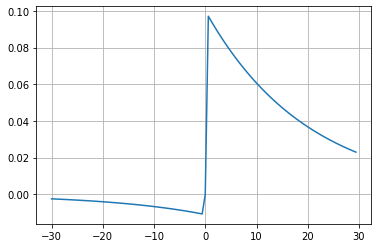

In [20]:
##### defino un vector de pesos
w = torch.ones(100) * 1

# defino vector de tiempos
extremo = 60 #mseg
dt = (torch.tensor(range(len(w))) - len(w)/2)/(len(w/2)) * extremo

out = deltaw_Morr(dt,w)

plt.plot(dt.numpy(), out.numpy())
plt.grid()
plt.show()



# Modelos STDP correspondiente al Estriado

## Sinapsis cortico-estriatal - Neuronas espinosas.

Fino et all 2005 estudiaron la interacción entre neuronas del layer V de la corteza somatosensorial y las neuronas espinosas estriatales (via directa me parece, pero en este paper no importaria). En este paper no consideran un tercer factor, es decir neurotransmisores que modulan el aprendizaje. Determinan que estimulación con pulsos de alta frecuencia (HFS) imponen procesos LTP, principalmente por mecanismos pre-sinapticos. Por otro lado, la estimulación en baja frecuencia (LFS) produce LTD. No obstante, para las interacciones presinaptica-postinaptica se observa STDP anti-hebbiana.

### STDP Anti-Hebbiana.

Realizan experimentos donde se estimula al nivel V de la corteza somatosensorial a corriente constante, y se ajusta de manera tal que evoque un EPSC en el estriado entre 50 a 200pA de amplitud. Controlan que esta estimulación, a 0.1Hz no genere cambios en la EPSC estriatal.
El corrimiento temporal lo generan evocando un potencial de acción (AP) en la neurona post-sinaptica, aplicando un pulso de corriente depolarizante supraumbral en la neurona estriatal. Este protocolo de estimulación cortical y AP evocado en el estriado se repite 100 veces a 1Hz. Se plantean dos situaciones:

- **pre-post**: la corriente depolarizante se aplica previo al potencial de acción. Esta situación plantea la situación donde la actividad pre-sinaptica evoca un AP en la post-sinapsis.
- **post-pre**: en este caso, la actividad post sinaptica, es decir el AP, ocurre primero. Busca simular el caso donde la actividad pre-sinaptica no está participando en la generación del AP post sináptico. 

La siguiente figura (`figura 6-E`) muestra los resultados de este experimento.
<img src="img/fino_2005.png" alt="drawing" width="500"/> 

Es interesante notar que el STPD está invertido (anti-hebbiano). Es decir, la actividad **pre-post** plantea un aprendizaje **tLTD**, mientras que **post-pre** plantea un aprendizaje **tLTP**. 



Este descubrimiento fue muy interesante, por una parte porque encuentra un modelo STDP anti-Hebbiano en una estructura importante como es el estriado. Pero también plantea una estructura donde la información que no evoca un AP es relevante para la estructura. Esto puede significar que el estriado ¨busca¨ relacionar información temporal, ya que esa información presinaptica, que no activa la neurona, lo hará en un futuro, ya que se potencia mediante tLTP, y todo en una ventana de $\pm 30 mseg$.

Existen terceros factores en STDP (Fino et al 2010, Feldman et al 2012, Paille et al 2013) que modifican la dinámica de la plasticidad. Tres neurotransmisores modulan la actividad de las neuronas estriatales, además de $glu^+$ que es el principal neurotransmisor en la actividad cortico-estriatal: dopamina, acetilcolina ($ACh$) y $GABA_A$. Vamos a dar una mirada acerca de cada neurotransmisor, y cómo influye en la plasticidad de las neuronas espinosas estriatales.

       



## Neurotransmisores en STDP en neuronas espinosas estriatales.

La primer aproximación no contempla el involucramiento de diferentes neurotransmisores en la plasticidad, tales como dopamina, $GABA_A$, y acetilcolina. Tampoco se consideraron las diferentes interneuronas, que en si mismas conforman una topología de red que modula la actividad estriatal. 







### Relación de la Transmisión de $GABA_A$ con STDP en las neuronas espinosas estriatales.

Como se vio previamente, las neuronas espinosas estriatales tiene la particularidad de poseer un STDP reverso. Fino et al 2010 muestran que $GABA_A$ está implicado en esa reversión.

<img src="img/fig1_fino2010_bicuculine.png" alt="drawing" width="500"/> 

La figura superior es parte de la *figura 1* de Fino et al 2010. Se repiten los protocolos de estimulación pre-post y post-pre de Fino et al 2005, pero en este caso se definen grupos a los que se le aplica un tratamiento con  **bicuculina**. 
La bicuculina es un antagonista de receptores $GABA_A$, y por lo tanto se inhibe la transmisión GABAérgica. Se conoce que, en las neuronas espinosas, $GABA_A$ puede afectar la backpropagación de los potenciales de acción post-sinapticos.

Las neuronas espinosas poseen receptores proximales al soma con sinapsis provenientes de las FSI, y distales en el árbol dendritico, con sinapsis entre neuronas estriatales (Burke et al 2017). 

No se observaron efectos de la bicuculina en cuanto a la backpropagación de los AP, pero sí se observan efectos sobre STDP. De acuerdo a Fino et al 2010, la interrupción de la transmisión $GABA_A$ revierte la plasticidad, haciendo que sea **LTP para pre-post** y **LTD para post-pre**. Es decir, sin el circuito $GABA_A$ el mecanismo de STDP es equivalente al encontrado mayoritariamente: *potenciación cuando la post-sinapsis tiene actividad consecuente con la pres-sinapsis* 

Ahora bien, los mecanismos de LTP y LTD son los mismos, es decir, LTP es un mecanismos posts-sináptico, dependiente de los canales **NMDA,** y LTD es un mecanismo pre-sináptico, dependiente de los **CB1R** presinapticos los cuales se activan a partir de receptopres metabotrópicos de $glu+$, **mGluR5**, y de un circuito endocanabinoide dependiente de receptopres **M1R** (ver más adelante y Fino et al 2010).

Por lo tanto un cambio de signo, $f_{\neg GABA_A}(\Delta t) \ne - f(\Delta t)$, no es una buena adaptación, ya que se tiene un tipo de adaptación con la dinámica de la otra, eso implicaría que los mecanismos responsables de, por ejemplo, LTD ahora promueven LTP. Sería equivalente a plantear que los receptores NMDA participan en el mecanismo LTD, y es por lo tanto erróneo.

Se aprecia más adecuado un modelo que proponga $f_{\neg GABA_A}(\Delta t) \sim f(- \Delta t)$.

##### Propuesta de Adaptación para $GABA_A$

Una propuesta para adaptar el modelo puede ser la siguiente:

$$f_1(\Delta t) = f(\gamma_{GABA_A} \Delta t)$$

siendo una función de la corriente $GABA$, la cuál cambia el signo de $\Delta t$: $\gamma_{GABA_A} \sim sign(i_{GABA_A} - i_{ref})$, donde $i_{ref}$ es una corriente de referencia a partir de la cual hay reversión. 


### Dopamina


Además sobre las neuronas estriatales, estas se dividen en neuronas estriatales de la vía directa, que expresan receptores dopaminergicos tipo I ($D_1$) y estriatales de la vía indirecta, que expresan receptores dopaminergicos tipo II ($D_2$). Sobre $GABA_A$ nos referiremos más adelante, pero en los estudios relativos a la incidencia de este neuroansmisor, **Paille et al 2013** consideraron diferenciar a las neuronas espinosas  entre aquellas $D_1^+$ y $non D_1^+$, observando la plasticidad en un caso *control*, `(C) en la tabla`, y restringiendo la expresión de los $GABA_AR$, `(GR-) en la tabla`. Para ello aplicaron  PTX, el cual es un bloqueador de los receptores, y también bicuculina y gabazina que son competidores antagonista para $GABA_AR$.  

|           |pre-post (C)|post-pre (C) |pre-post (GR-)               |post-pre (GR-)  |
|-----------|------------|-------------|-----------------------------|----------------|
|$D_1^+$    |**tLTD**    |-            |**tLTP** (NS) / *tLTP* ($*$) |- / *tLTD* ($*$)|
|$non D_1^+$|**tLTD**    |**tLTP**     |**tLTP**                     |**tLTD**        |

Los resultados para las neuronas $non D_1^+$ muestran plasticidad anti-hebbiana, como es esperado en control, y reversión a hebbiano en el caso de (GR-). En el caso de neuronas $D_1^+$ sólo observaron plasticidad para una configuración pre-post, la cuál se plantea como anti-hebbiana asimétrica. En el caso (GR-) observan una reversión, pero esta no es significativa (NS). Esto se puede apreciar en la `figura 2-A` de Paille et al 2013 donde hay una tendencia claramente no significativa a tLTP para pre-post con tratamiento de PTX. 


**Pawlak y Kerr 2008** encuentran en experimentos *ex vivo* que **tLTD y tLTP requieren activación de $D_1R$, pero no $D_2R$**. Respecto a los $D_2R$ plantean que tienen un rol en la dinámica, por ejemplo, la aplicación de antagonistas de $D_2R$ acelera el proceso de plasticidad, pero el resultado final es el mismo. También determinan que la plasticidad es de tipo Hebbiana, pero sus experimentos se hicieron en presencia de picrotoxine (PTX), esto concuerda con los resultados de Fino et al 2010 respecto a $GABA_AR$. No determinan si las neuronas estriatales observadas pertenecen a la vía directa o indirecta. No obstante, comparando con los resultados de Paille et al 2013, se observa que las neuronas $non-D_1^+$, con mayoría de $D2R$, mostraron plasticidad significativa. Pudiera ir en linea, entonces, con lo determinado para $D_2R$ por Pawlak y Kerr 2008, donde $D1R$ sí juega un rol determinante para las neuronas de la vía directa.

**Shen et al 2008**, empleando otra metodología, encuentra que las neuronas de la vía indirecta requieren de activación de $D_2R$ para tLTD, mientras que la vía directa requiere activación de $D_1R$ para tLTP.

**Schulz et al 2010** observan STDP hebbiano en experimentos *in vivo*, con un protocolo de estimulación similar al de Pawlak y Kerr 2008 pero sin picrotoxine, cuando se aplica bicuculina al culículo superior (ColS). Esta aplicación produce la desinhibición del ColS, que a su vez libera los circuitos visuales y se espera que esto produzca liberación de dopamina. `Es decir, la aplicación de dopamina es indirecta, y no se aprecia controlada`. Sin aplicación de bicuculina no observan plasticidad (figura 6 de Schlz et al 2010). En relación a que observan plasticidad hebbiana, los experimentos se hicieron en una ventana muy ajustada, dentro de los $|3 mseg|$ de relación pre-post, considerando un sólo factor, y se ajustó el experimento para ese comportamiento. En las discusiones no entran en contraposición con Fino et al 2005,donde la ventana es $|40mseg|$. **La conclusión para Schulz et al 2010 es que dopamina es necesaria para que exista STDP.**

Es claro que dopamina tiene un rol en STDP, y conforma uno de los factores de STDP en las SPN. Si bien no se conocen los procesos, es aceptado el planteo de Shen et al 2008 acerca de que $D_1R$ son necesarios para tLTP y $D_2R$ son necesarios para tLTD. La activación de los receptores D1 acoplados a proteínas $G\alpha olf$ tienden a promover LTP, mientras que la activación de receptores D2 acoplados a proteínas $G\alpha i$ tienden a promover LTP. Pero existen otros factores, como los de red, que pudieran modelar la plasticidad. Las neuronas parvalvumina positivas poseen $D_2R$, por lo tanto un aumento de los niveles de dopamina implican en principio una reducción en la actividad de estas neuronas, y por lo tanto, una reversión a un STDP hebbiano, disponiendo a la neurona a un STDP hebbiano.

#### Propuesta para Dopamina

En el modelo de red, dopamina implica una facilitación de la actividad en la **vía directa**, y con ello una facilitación de procesos de plasticidad. La vía directa posee receptores , y como se mencionó antes, estos receptores están acoplados a proteínas $G\alpha olf$ que promueven LTP. LTP y tLTP no son el mismo proceso, en STDP el ingreso de $Ca_2^+$ es dependiente de la relación temporal entre la actividad pre y la backpropagación de los potenciales de acción. En la vía directa la dopamina promueve la formación de potenciales de acción, donde Pawlak y Kerr determinan que los receptores $D_1R$ son necesarios tanto para tLTP como tLTD, entonces puede aceptarse el hecho de que la facilitación dada por la dopamina, es principalmente en la actividad. 
    
Esto no implica que la dopamina sea un factor determinante para la plasticidad. Shulz et al 2010 también observa procesos tLTD y tLTP en la vía directa, modulados por $GABA_AR$, desde ya, pero los procesos están, y sin control de dopamina.
    
Posiblemente esta condición de red proponga para la vía directa mayor preponderancia de tLTP, no obstante hay otro factor, la acetilcolina, que lo vamos a considerar más adelante, y sería un promotor de tLTD, tanto para la vía directa como indirecta.

Para el caso de la **vía indirecta**, ésta posee mayoritariamente receptores $D_2R$, donde su activación promueve procesos LTD, así como una reducción en la probabilidad de expresión de potenciales de acción. Pero también se observó que los procesos de plasticidad se aceleran, tanto para tLTD como tLTP. 

A su vez, las neuronas dopaminergicas poseen receptores $D_2R$ que autoregulan la expresión de dopamina, además las neuronas de la vía directa se conectan entre ellas, reduciendo o deteniendo el influjo de $GABA_A$ en los colaterales, y con ello deja de existir oposición a los AP backpropagados, facilitando la plasticidad. También las FSI poseen receptores D2, por lo tanto también se reduce la cantidad de $GABA_A$ en el soma, y por lo tanto hay una tendencia a revertir de anti-hebbiano a hebbiano.

Como se observa, los efectos de dopamina en STDP se aprecian relativos a la red, principalmente por el desconocimiento que existe. 

<div class="alert alert-block alert-info">
<b>Vía directa.</b>    
    Entonces, se va a considerar, inicialmente, que la dopamina promueve tLTP y tLTD mediante la facilitación a la depolarización que implica la activación de los receptores $D_1R$, y por lo tanto facilitando la expresión de un potencial de acción post sinaptico, quedando la plasticidad definida por la relación pre-post eventual.

<b>Vía indirecta.</b> 
    En este caso, también se van a estudiar los efectos de red que afecten al aprendizaje, pero es posible incluir una modulación que reduzca la velocidad de aprendizaje cuando se expresa $D_2R$, de acuerdo a lo observado por Pawlak y Kerr 2008.
</div>



### Acetilcolina

Como se dijo previamente, las MSN se pueden diferenciar en:
- *neuronas de la vía directa*, las cuales proyectan al Globo Pálido interno y a la Substantia Nigra pars reticulata, también llamada vía striatonigral, y poseen receptores dopaminérgicos tipo $D_1R$ y receptores muscarínicos tipo $M_1R$ (excitatorios) y de tipo $M_4R$ (inhibitorios) en una relación 50%-50%. 
- *neuronas de la vía indirecta*, proyectan al globo pálido externo, también llamada vía striatopalidal, con receptores dopaminergicos $D_2R$, y muscarínicos $M_1R$ y $M_4R$ pero en una proporción 75% - 25% respectivamente.

Es decir, en la vía directa, los efectos excitatorios e inhibitorios podrían considerarse de cierta forma compensados, no así en la vía indirecta, donde la acetilcolina promueve la actividad.

`Nota: hay que buscar alguna referencia sobre las proporciones, no recuerdo de donde lo saqué`

Fino et al 2010 determina que $M_1R$ son un factor de coincidencia que promueven tLTP, donde tLTD en las neuronas espinosas se puede dar pre-post, es decir antihebbiano, dependiendo de $GABA_AR$. Otro factor que promueve tLTD son los receptores metabotrópicos de glutamato $mGluR5$, en paralelo con los receptores muscarínicos. 
<div class="alert alert-block alert-info">
Entonces, una posibilidad es considerar a los $M_1R$ como facilitadores de procesos tLTD, es decir, un proceso LTD en la terminal sináptica, corti-estriatal, inducido por acetilcolina. 
    
<b>En la vía directa</b> acetilcolina y dopamina tiene de alguna manera roles diferentes, siendo dopamina facilitadora de tLTP, acetilcolina puede ser facilitadora de tLTD.
    
 <b>en la vía indirecta</b>, los receptores $M_1R$ aumentan la posibilidad de disparo frente a determinada entrada sensorial, que también es entrada de las interneuronas dopaminérgicas. Esto puede inducir actividad pre-post que es tLTD.

Como sea, al igual que con dopamina, se va a estudiar los efectos de red, y luego introducir modificaciones que incluyan los efectos particulares de los receptores $M_1R$
</div>



### Aproximación a un modelo de STDP para neuronas estriatales.


#### Auxiliares:
Función gaussiana:

In [21]:
def fgauss(x,loc=0,scale=1):
    # Son las funciones de la base del espacio del estimador.
    # scale es el desvío standard
    funcion = norm(loc=loc, scale=scale)
    return funcion.pdf(x)

In [22]:
# Para la aplicación deberíamos usar esto
from torch.distributions.normal import Normal
m = Normal(torch.tensor([0.0]), torch.tensor([1.0]))
m.log_prob(0).exp()

tensor([0.3989])

Se va a partir de los datos medidos por Fino et al 2005 (figura superior), los cuales se transcriben en el siguiente vector: 


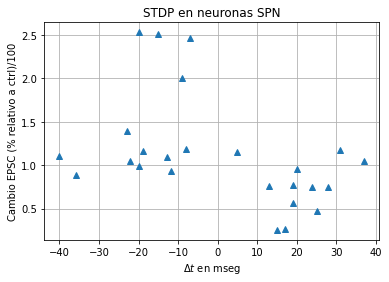

In [23]:
# Se extraen los datos presentados en la figura 6-E (Fino et al 2005)

delta_t = np.asarray([-40, -35.8, -22.96, -22.13, -19.9,-19.89, -18.96, -14.96, -12.78, -11.79,  
                        -9.09,  -7.95, -7.01,  4.94, 12.94, 14.96, 17.04, 18.96,
                      18.96, 20.05, 23.89, 24.99, 27.90, 30.91, 36.94])

y_stdp = np.asarray([110, 88.4, 139.2, 104.61, 253.08, 98.8, 115.76, 251.15,108.85, 92.69, 
                       200.38,  118.08, 246.15, 115, 76.15, 25.38, 26.54, 56.92,
                     76.92, 95.38, 74.84, 47.30, 74.61,  116.92, 104.6])


y_stdp = y_stdp/100
delta_t = delta_t.reshape(len(delta_t),1)
y_stdp = y_stdp.reshape(len(y_stdp),1)

plt.plot(delta_t,y_stdp,'^')
plt.title('STDP en neuronas SPN')
plt.ylabel('Cambio EPSC (% relativo a ctrl)/100')
plt.xlabel(r'$\Delta t$ en mseg')
plt.grid()

### Dos gaussianas con media y varianzas estimadas.
 Vamos a proponer un modelo con dos gaussianas ($M = 2$), donde la media y varianza se ajustan ajustadas a las muestras para $t >0$ en un caso, y $t<0$ para la otra gaussiana.
Desde ya, la media y la varianza está dada por la concentración de datos en el tiempo. También se propone un parámetro $\alpha >0$ el cual reduce la varianza para $\alpha >1$. Se probaron otras opciones, pero esta es la que más gustó, porque es más simple.

In [24]:
from scipy.stats import norm
from itertools import product

In [25]:
def f_aprox(x, parameters, flag=None ):
    """
    Función de aproximación
    :x: delta de tiempos expresados como pre-post
    :parametros: ( Coeficientes, Media_y, Loc, Scale )
    :flag: permite indicar la variacón de una sola vía.
    
    :return:
    """
    w = parameters[0]
    media = parameters[1]
    loc_vect = parameters[2]
    desvio = parameters[3]  # scale es el desvio
    out = np.zeros(x.shape)
    if flag==None:
        for i in range(len(w)):
            out = w[i] * fgauss(x,loc=loc_vect[i], scale=desvio[i]) + out
        return out + 1
    else:
        out = w[flag] * fgauss(x,loc=loc_vect[flag], scale=desvio[flag]) 
        return out + 1

def estimador(x,y,alpha = 1):
    """
    Estimación sobre una base de dos gaussianas
    :x: muestras
    :y: f(x)
    :alpha: parametro que modula el desvío de las gaussianas
    
    :return: (w, media, mean_est, var_est)
            w: Coeficientes
            media: Media_y
            mean_est: Loc
            des_est: Scale
    """
    M = 2 # la cantidad de gaussianas
    mean_est = []  # media de las gaussianas
    mean_est.append(np.mean(x[x <0]))
    mean_est.append(np.mean(x[x >0]))
    mean_est = np.asarray(mean_est)
    
    des_est = []  # desvio de las gaussianas
    des_est.append(np.std(x[x <0]))
    des_est.append(np.std(x[x >0]))
    des_est = np.asarray(des_est)/alpha
    
    media = np.mean(y)
    y = y - media
    Q = np.zeros((len(x),M))
    for i in range(M):
        Q[:,i] = fgauss(x,loc=mean_est[i], scale=des_est[i])[:,0]
    
    # Aproximación por minimos cuadrados (linales)
    Q_pinv = np.linalg.pinv(Q)
    w = np.matmul(Q_pinv, y)
    
    return (w, media, mean_est, des_est)


Resultados:
Coeficientes:  [[ 11.57668887]
 [-11.39801786]]
Media_y:  1.1270840000000002
Loc:  [-18.70923077  21.04      ]
Scale:  [9.68856539 8.2078763 ]


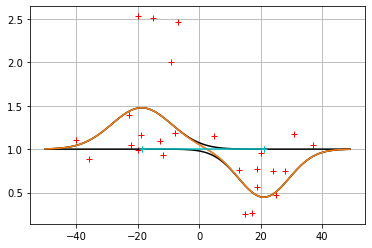

In [26]:
##############################
### AJUSTE DEL MODELO STDP ###
##############################

# Se va a generar un MODELO
alpha = 1
parameters = estimador(delta_t, y_stdp, alpha=alpha)

# Evaluación del MODELO
rango = np.asarray(range(100))-50 
salida = f_aprox(rango, parameters)

#Grafico y Resultado
plt.plot(rango, salida)
plt.plot(delta_t,y_stdp, 'r+')
plt.plot(parameters[2], np.zeros((len(parameters[2]),1))+1, 'c+')
for i in range(2):
    plt.plot(rango, f_aprox(rango, parameters, flag=i), 'k')
plt.plot(rango, salida)
#plt.plot(rango, np.zeros(rango.shape)+1,'k')
plt.plot(parameters[2], np.zeros((len(parameters[2]),1))+1, 'c+-')
plt.grid()

print('Resultados:')
print('Coeficientes: ', parameters[0])
print('Media_y: ', parameters[1])
print('Loc: ', parameters[2])
print('Scale: ', parameters[3])

### Adecuación del modelo
Hasta aquí se tiene un modelo basado en datos, donde la amplitud se obtiene a partir de un protocolo consta de **100** estimulaciones tipo **LFS** con pulsos a 1HZ, en configuración pre-post y post-pre (`figura 6` de Fino et al 2005).

<img src="img/fig_6_STDP_prep_postp.png" alt="drawing" width="500"/> 


El modelo de plasticidad se hace sobre datos que se tienen a los 45 minutos de la estimulación. No voy a modelar esa dinámica, siendo que un cambio en la dinámica puede resetear a la anterior, por lo menos es lo que se observa en las estimulaciones **LFS** y **HFS** intercaladas (Fino et al 2005), es esperable que en la naturaleza la potenciación o depotenciación efectiva, de determinada actividad, se dé por una suerte de competencia estadística entre potenciaciones y depotenciaciones, tal vez en una suerte de convergencia a la media de un proceso tipo Bernoullí.




Entonces, se determinó una dinámica donde para alguna EPSC control $w(0)$ se obtiene $w(100) = w(0)~ \mathcal{f}(\phi_M, \Delta t)$, donde $\mathcal{f}(\phi_M, \Delta t)$ es la función obtenida a partir de la regresión realizada sobre los datos de la `figura 6-E` de Fino et al 2005. $\mathcal{f}(\phi_M, \Delta t)$ posee tres términos,

$$\mathcal{f}(\phi_M, \Delta t) =  \eta_+ ~ \phi_+(\mu_+, \sigma^2_+,\Delta t) + \eta_- ~ \phi_-(\mu_-, \sigma^2_-,\Delta t) +1$$

siendo $\phi$ funciones gaussianas, para las cuales se determinaron los siguientes parámetros:

- **loc**  $~\mu_+$ = -18.71,  $~\mu_-$ = 21.04
- **scale**  $~\sigma_+$ = 9.69,  $~\sigma_-$ = 8.20
- **coeficientes**  $~\eta_+$ = 11.58,  $~\eta_-$ = -11.40

A partir de lo anterior, se propone que la variación de la EPSC por STDP en las neuronas estriatales tengan la forma:

$$\Delta w = \lambda ~ w ~ \eta_+ ~ \phi_+(\mu_+, \sigma^2_+,\Delta t) + \lambda ~ \alpha ~ w ~ \eta_- ~ \phi_-(\mu_-, \sigma^2_-,\Delta t)$$

de manera tal que $\Delta w \propto w$, en línea a lo propuesto por Song et al 2000, donde $\lambda$ es una constante que adapta la velocidad de potenciación y $\alpha$ lo hace para la depotenciación. Se pueden distinguir entonces dos componentes, una componente LTP y otra LTD:

$$ \Delta w_+ = \lambda ~ w ~ \eta_+ ~ \phi_+(\mu_+, \sigma^2_+,\Delta t)$$

$$ \Delta w_- = \lambda ~ \alpha ~ w ~ \eta_- ~ \phi_-(\mu_-, \sigma^2_-,\Delta t)$$



Entonces se deben determinar $\lambda$ y $\alpha$ tales que se cumpla $w(100) = w(0)~ \mathcal{f}(\phi_M, \Delta t)$ luego de 100 interacciones.

De acuerdo a Fino et al 2005, la variación media, $w(100) = \beta ~ w(0)$, como porcentual relativo a $w(0)$ es, en LTP es $\beta_+ = 141 \pm 17 \%$, adoptando $\beta_+ = 1.41 $ y en LTD es $\beta_- = 25 \pm 9\%$, es decir, $\beta_- = 0.25 $.

Siendo entonces el modelo STDP para las neuronas estriatales

$$ w(n) = w(n-1) + \Delta w ~ = ~ w(n-1) + \left ( \Delta w_+^{[w(n-1)]} + \Delta w_-^{[w(n-1)]} \right )$$

$$ w(n) = w(n-1) + \Delta w ~ = ~ w(n-1) + \lambda ~ w(n-1) ~ \eta_+ ~ \phi_+(\Delta t) + \lambda ~ \alpha ~ w(n-1) ~ \eta_- ~ \phi_-(\Delta t)$$


$$ w(n) = w(0) \left ( 1 + \lambda  ~ \eta_+ ~ \phi_+(\Delta t) + \lambda ~ \alpha ~ \eta_- ~ \phi_-(\Delta t) \right )^n$$

y por lo tanto, se tiene que 

$$ \beta ~=~ \left ( 1 + \lambda  ~ \eta_+ ~ \phi_+(\Delta t) + \lambda ~ \alpha ~ \eta_- ~ \phi_-(\Delta t) \right )^{100} $$




$$
\left\{
    \begin{array}\\
        \lambda  ~ \eta_+ ~ \phi_+(\mu_+) + \lambda ~ \alpha ~ \eta_- ~ \phi_-(\mu_+) &  \ = \ & \sqrt[100]{\beta_+} - 1 \\
        \lambda  ~ \eta_+ ~ \phi_+(\mu_-) + \lambda ~ \alpha ~ \eta_- ~ \phi_-(\mu_-) &  \ = \ & \sqrt[100]{\beta_-} - 1 
    \end{array}
\right.
$$

y a partir de este sistema se determina $\lambda$ y $\alpha$.



In [27]:
#### Cálculo de parámetros de adecuación del modelo
p = parameters

A = np.asarray([[p[0][0][0]*fgauss(p[2][0],loc=p[2][0],scale=p[3][0]), p[0][1][0]*fgauss(p[2][0],loc=p[2][1],scale=p[3][1])],
                [p[0][0][0]*fgauss(p[2][1],loc=p[2][0],scale=p[3][0]), p[0][1][0]*fgauss(p[2][1],loc=p[2][1],scale=p[3][1])]])
B = np.asarray([[(1.41 ** (1/100) - 1)], [(0.25 ** (1/100) - 1)]])
X = np.linalg.inv(A).dot(B)
lamb_spn = X[0][0]
alpha_spn = X[1][0]/lamb_spn

print('lambda: ', lamb_spn)
print('alpha: ',alpha_spn)

lambda:  0.007220471050990632
alpha:  3.441902253366466


---
#### Modelos preliminar de STDP para neuronas espinosas del estriado:

Queda definido el modelo preliminar como:

$$\Delta w = \lambda ~ w ~ \eta_+ ~ \phi_+(\mu_+, \sigma^2_+,\Delta t) + \lambda ~ \alpha ~ w ~ \eta_- ~ \phi_-(\mu_-, \sigma^2_-,\Delta t)$$

siendo 

- **loc**  $~\mu_+$ = -18.71,  $~\mu_-$ = 21.04
- **scale**  $~\sigma_+$ = 9.69,  $~\sigma_-$ = 8.20
- **coeficientes**  $~\eta_+$ = 11.58,  $~\eta_-$ = -11.40
- **parámetros de adecuación** $\lambda = 0.0072$, $\alpha = 3.44$
---


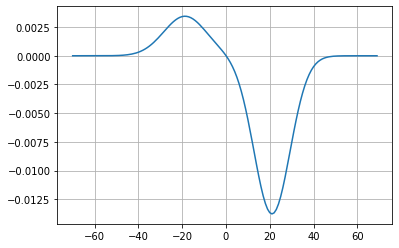

In [28]:
### Visualización de los resultados - Modelo
def dw_spn(del_t, p, lamb, alpha, w):
    out = np.zeros(del_t.shape)
    
    out += lamb * w * (p[0][0] * fgauss(del_t,loc=p[2][0], scale=p[3][0]) + 
                       alpha * p[0][1] * fgauss(del_t,loc=p[2][1], scale=p[3][1]))
    
    return out

d_t = np.asarray(range(140))-70
d_t = np.reshape(d_t,(len(d_t),1))
d_w = dw_spn(d_t, parameters, lamb_spn, alpha_spn, w=1)
plt.plot(d_t,d_w)
plt.grid()

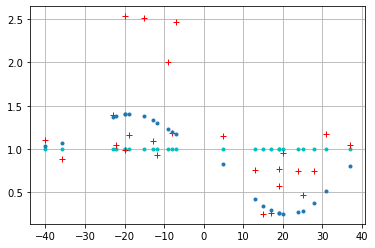

In [29]:
### Visualización para una repetición de 100 interacciones.
pesos = np.zeros(delta_t.shape)+1
for i in range(100):
    pesos = pesos + dw_spn(delta_t, parameters, lamb_spn, alpha_spn, w=pesos)


# Pesos originales
plt.plot(delta_t,np.zeros(delta_t.shape)+1,'c.')
plt.plot(delta_t,y_stdp, 'r+')
# Pesos modificados
plt.plot(delta_t,pesos,'.')    
plt.grid()
plt.show()


## STDP en Fast Spiking Interneurons (FSI)

Fino et al 2008 analiza STDP en las interneuronas FSI y colinérgicas. En el caso de las FSI, estudian STDP con un protocolo idéntico al realizado en Fino 2005, el resultado es el siguiente, donde se observa aprendizaje hebbiano (fig3-c), 

<img src="img/fig_3_fino_2008_stdp_FSI.png" alt="drawing" width="500"/> 

Se va a seguir Morrison 2007 para modelar la plasticidad en FSI, y por lo tanto, la variación de pesos tiene la ley:

$$ \Delta w^+ = \lambda ~  w_0 ^{1-\mu} ~ w^\mu ~ e^{-\frac{|\Delta t|}{\tau}}$$
$$ \Delta w^- = - ~ \lambda ~  w ~ \alpha ~ e^{-\frac{|\Delta t|}{\tau}}$$

Como la dinámica está definida, vamos a determinar los parámetros. 
En primer lugar, $\mu$ ajusta la incidencia de la EPSC en la variación de la potencia sináptica. Morrison se basa en resultados de BI & Poo 1998 para ajustar un valor de $\mu$. En el caso de Fino et al 2008 no se tienen esos resultados, y  no es posible estimarlos, ya que no se tienen resultados relativos a la corriente postsinaptica inicial y su variación por plasticidad. Vamos a considerar que $\Delta w \propto w$ de igual manera para LTP y LTD, por lo tanto queda **$\mu = 1$**.

No se detectó STDP más allá de una ventana de $-50~ms$, esto nos permite ajustar la constante de tiempo $\tau = 10ms$. En la siguiente gráfica se puede ver que ese valor es apropiado.

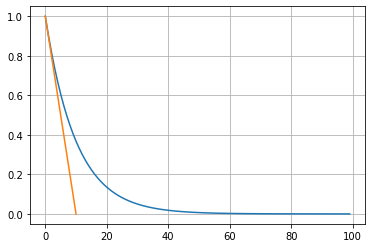

In [30]:
tau = 10
dt = np.asarray(range(100))
dw = np.exp(-dt/tau)
plt.plot(dt,dw)
plt.plot([0,tau],[1,0])
plt.grid()

Para obtener la velocidad $\lambda$, se sigue en parte los planteado por Morrison et al 2007. Se va a tomar un $\Delta t$ particular, y un $\Delta w^+$. De acuerdo al protocolo, a partir de una condición inicial $w(0)$, se estimulan 100 veces, y al final se obtiene una variación $w(100) = \beta ~ w(0)$. Considerando la dinámica de plasticidad propuesta,
$$\Delta w^+ = \lambda w e^{-\frac{|\Delta t|}{\tau}}$$

se tiene entonces:

$$w(1) = w(0) + \lambda ~ w(0) ~ e^{-\frac{|\Delta t|}{\tau}} = w(0)~ \left ( 1+ \lambda e^{-\frac{|\Delta t|}{\tau}} \right ) $$

es fácil demostrar por inducción que

$$w(n) =  w(0)~ \left ( 1+ \lambda e^{-\frac{|\Delta t|}{\tau}} \right )^n $$

donde particularmente nos importa $w(100) = \beta ~ w(0)$, de lo que resulta 

$$ \lambda = \left ( \sqrt[100] \beta - 1 \right )~ e^{\frac{|\Delta t|}{\tau}}$$ 

Fino et al 2008 miden una potenciación LTP de $74.6 \pm 17.7 \%$, y por lo tanto se adopta $\beta = 1.75$ para 100 estimulaciones. Si bien no hay referencias específicas a valores de $\Delta t$, a partir de la `figura 3-c` se propone que $\Delta t = 9ms$. Bajo estas condiciones, resulta $\lambda = 0.014$

En cuanto a la depotenciación (LTD), se debe determinar el parámetro $\alpha$. Siendo,

$$\Delta w^- = -~ \lambda ~ \alpha ~ w ~ e^{-\frac{|\Delta t|}{\tau}}$$

y siendo $\gamma$ el coeficiente que determina la depotenciación desde una condición inicial $w(0)$ para 100 estimulaciones, $w(100)=\gamma~w(0)$, siguiendo el razonamiento para LTP, se tiene que
$$ \alpha = \left ( 1 - \sqrt[100] \gamma \right )~ \frac{1}{\lambda}~e^{\frac{|\Delta t|}{\tau}}$$ 

Determinaron que con LTD se tiene una depresión de $-63.7 \pm 7.4 \%$ relativo al control, $w(0)$ en este caso. Eso implica $\gamma = 0.37$, y al igual que antes, se propone $\Delta t = 9ms$. Con estas aproximaciones, se tiene que $\alpha = 1.74$. 

---
#### Modelo STDP para FSI

El modelo queda definido, entonces por las siguientes ecuaciones:

$$ \Delta w^+ = \lambda ~  w ~ e^{-\frac{|\Delta t|}{\tau}}$$
$$ \Delta w^- = - ~ \lambda ~  w ~ \alpha ~ e^{-\frac{|\Delta t|}{\tau}}$$

siendo la velocidad de potenciación $\lambda = 0.014$, la adaptación para LTD $\alpha = 1.74$, y $\tau = 10ms$. 

---



In [31]:
def dw_fsi(delta_t):
    lamb = 0.014
    alpha = 1.74
    tau = 10
    out = np.zeros(delta_t.shape)
    w = 1
    
    out += lamb * w * np.exp(-np.abs(delta_t)/tau)*(delta_t >= 0)
    out -= lamb * alpha * w * np.exp(-np.abs(delta_t)/tau)*(delta_t < 0)
    return out

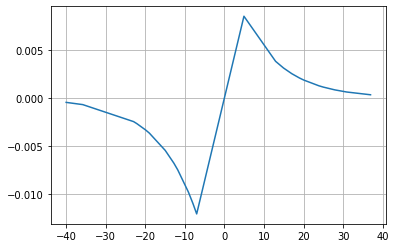

In [32]:
delta_w = dw_fsi(delta_t)
plt.plot(delta_t,delta_w)
plt.grid()

## STDP en interneuronas colinérgicas.

Las interneuronas colinérgicas presentan,

- post - pre : tLTD cuando los niveles de excitabilidad (rheobase) son bajos, en caso contrario LTP. Es decir, pareciera que depende de la excitabilidad de la neurona. Aparentemente la relación de interneuronas que expresan tLTP es 1.3 veces más que aquellas que expresan tLTD. Fino et al 2008.
- pre - post: es tLTD.

También determina que tLTP depende de receptores NMDA, mientras que tLPD depende de receptores metabotrópicos de glutamato. En su configuración antihebianna, es decir post-pre tLTP y pre post tLTD, se puede emplear el modelo para neurona estriatal, sin las consideraciones relativas a $M_1R$.

<div class="alert alert-block alert-info">
    
La implementación de STDP para las neuronas colinérgicas se implementará de acuerdo con,
    <ul>
        <li> <b> por defecto se considera anti-hebbiano, pre-post: tLTD y post-pre: tLTP </b></li>
        <li> el aprendizaje se implementará empleando el modelo STDP de las SPN estriatales, descripto previamente, y teniendo en cuenta que:
            <ol>
                <li> Se excluye la modulación dada por $GABA_AR$ que son particulares de las SPN. </li>
                <li> Se excluye la acción de los receptores $M_1R$ como promotores de tLTD.</li> 
            </ol>
        </li>  
        <li> <b>post-pre</b> se debe estudiar la variación de las corrientes antes del potencial de acción en el modelo para tener referencias y generar un umbral de cambio entre tLTP y tLTD, los cuáles dependen del nivel de excitabilidad de la interneurona. </li>
    </ul>

</div>

# Anexo
#### Aproximación con múltiples gaussianas
Se tienen como hiperparametros a $M$ y $\alpha$, donde $M$ es la cantidad de funciones gaussianas y $\alpha$ modula el desvío estándar de las gaussianas de manera inversamente proporcional.. 

In [33]:
def f_detalle_a(x, parameters, flag=None ):
    w = parameters[0]
    media = parameters[1]
    loc_vect = parameters[2]
    sigma = parameters[3]
    out = np.zeros(x.shape)
    if flag==None:
        for i in range(len(w)):
            out = w[i] * fgauss(x,loc=loc_vect[i], scale=sigma ** 2) + out
        return out + 1
    else:
        out = w[flag] * fgauss(x,loc=loc_vect[flag][0], scale=sigma ** 2) 
        return out + 1

def estimador_a(x,y,M, alpha):
    max_t = max(x)
    min_t = min(x)
    sigma = (max_t - min_t)/M/alpha # SD de las gaussianas => solapa con el 31.8% del área a las otras.
    loc_vect = np.asarray([i * (max_t-min_t)/M + (min_t + (max_t-min_t)/2/M) for i in range(M)])
    media = np.mean(y)
    y = y - media
    Q = np.zeros((len(x),M))
    Q = np.zeros((len(x),M))
    for i in range(M):
        Q[:,i] = fgauss(x,loc=loc_vect[i], scale=sigma ** 2)[:,0]
        
    Q_pinv = np.linalg.pinv(Q)
    w = np.matmul(Q_pinv, y)
    # Calculo de metrica de AKAIKE
    y_est = f_detalle_a(x, (w, media, loc_vect, sigma))
    aic = 2*M + len(x)* np.log(2*np.pi*sigma**2)+1/(sigma ** 2) * (np.linalg.norm(y-y_est)**2)
    return (w, media, loc_vect, sigma, aic)



Si probamos aplicando el criterio de Akaike, el resultado va a ser overfitting. Busca aproximar a todos los puntos. No nos sirve

In [34]:
MM_range = range(3,11)
aa_range = range(3,9)
resultado = []
for k in product(MM_range,aa_range):
    aux = [k[0], k[1], estimador_a(delta_t, y_stdp, M=k[0], alpha = k[1])[4][0] ]
    resultado.append(aux)
resultado = np.asarray(resultado)
# minimo akaike
resultado[resultado[:,2]==min(resultado[:,2]),:]

array([[ 7.        ,  8.        , 93.16450609]])

La siguiente solución, con $M = 2$ y $\alpha = 13$ no está tan mal.

[[ 10.31370477]
 [-12.29286443]]
1.1270840000000002


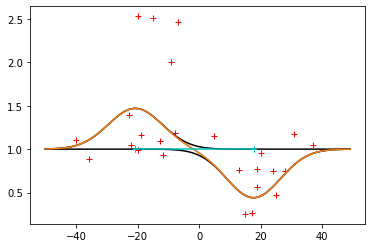

In [35]:
MM = 2 #4 5 5 6 6 
aa = 13 #6 4 5 5 4

parameters = estimador_a(delta_t, y_stdp, M=MM, alpha = aa)
print(parameters[0])
print(parameters[1])

rango = np.asarray(range(100))-50
salida = f_detalle_a(rango, parameters)
plt.plot(rango, salida)
plt.plot(delta_t,y_stdp, 'r+')
plt.plot(parameters[2], np.zeros((len(parameters[2]),1))+1, 'c+')
for i in range(MM):
    plt.plot(rango, f_detalle_a(rango, parameters, flag=i), 'k')
plt.plot(rango, salida)
#plt.plot(rango, np.zeros(rango.shape)+1,'k')
plt.plot(parameters[2], np.zeros((len(parameters[2]),1))+1, 'c+-')

Como se ve, Akaike produce overfitting. No nos sirve como criterio. Y por otra parte, cómo se puede ver en el gráfico, no está mal esta combinación de dos gaussianas. 

In [36]:
lamb * (w0 ** (1 - mu)) * (w ** mu)

NameError: name 'lamb' is not defined

# BORRADOR DE COSAS A REUTILIZAR

## Sobre procesos LTP y LTD marcados por frecuencia de disparo. Hay que reescribir todo esto.

**justificando porque no vamos a emplear LTP y LTD por frecuencia, y sólo STDP**

Hasta aquí se tiene un modelo, el cual hay que ajustar, ya que la amplitud se obtiene a partir de los datos de la `figura 6` de Fino et al 2005, donde el protocolo consta de **100** estimulaciones tipo **LFS** con pulsos a 1HZ, en estado pre-post y post-pre. 
Comparando la `figura 4` de Fino el al 2005, donde muestran resultados del protocolo **LFS** para inducir LTP:
<img src="img/fig_4_LTD.png" alt="drawing" width="500"/> 

se puede observar que ese protocolo tiene la misma dinámica para, depotenciación y potenciación, salvando la dirección, que el protocolo empleado en STDP, según se puede apreciar en la `figura 6` del mismo trabajo  

<img src="img/fig_6_STDP_prep_postp.png" alt="drawing" width="500"/> 

Aparentemente la dinámica depende de la frecuencia, y es un proceso que continúa aún después de finalizar la estimulación. Pero por otra parte, Fino et al 2005 muestra que la expresión de un mecanismo (LTP o LTD) cancela la expresión del mecanismo de potenciación previo. Ver figura 5 de Fino et al 2005.

El modelo de plasticidad se hace sobre datos que se tienen a los 45 minutos de la estimulación. No voy a modelar esa dinámica, siendo que un cambio en la dinámica puede resetear a la anterior, es esperable que en la naturaleza la potenciación o depotenciación efectiva de determinada actividad se dé por una suerte de competencia estadística entre posiciones pre-post y post-pre, donde la resultante será LTP o LTD en una suerte de convergencia a la media de un proceso tipo Bernoullí.

##### Sobre la relación con la frecuencia
En cuanto a la dependencia con la frecuencia, se pueden ver los resultados de HFS en los trabajos de Fino 2005 y 2010, donde la frecuencia de estimulación es 100Hz y el potenciamiento es inmediato. De todas maneras, 100Hz es muy alta frecuencia para STDP, con $\Delta t \approx 0 mseg$ y en el caso de las neuronas estriatales, sin mayores cambios en la potencia sinaptica. Otra cuestión con la HFS relativa a STDP es que estadísticamente puede significar una estimulación pre-post o post-pre, ya que el ruido en la posición temporal puede cambiarla de categoría. Esto hace que se rompa la dinámica de potenciación continuamente. 
